In [1]:
!pip install itables
!pip install pingouin

In [2]:
%run '/Users/Study/Desktop/BIO project/Lab project - code /pickleContigs.ipynb'

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 
import pandas as pd
import numpy as np
import scipy.stats 
from scipy.stats import shapiro
import pingouin as pg
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def main(*folders_paths,sample_size,normalize=True):
  global NUM_OF_GENES 
  global NORMALIZE
  NUM_OF_GENES=sample_size
  NORMALIZE = normalize
  if NORMALIZE: print("structure counts are normalized by length"\
                      ", and expressed as a ratio per 1000 bases.")  
  viral_classes_names=[]
  df_list=[]

  for folder_path in folders_paths:
    virus_type=os.path.basename(folder_path)
    viral_classes_names.append(virus_type)
    df_list.append(createDf(folder_path))
  
  stacked_df = pd.concat([df.assign(viral_class = viral_class) for df, viral_class in zip(df_list, viral_classes_names)])
  stacked_df = stacked_df.reindex(['viral_class','name','length','stems means','multiloops means','hairpins means','interior loops means'], axis=1)
  display(stacked_df)


  ###statistical analysis###
  
  statistical_analysis(stacked_df,'multiloops means')
  kde_plot(stacked_df,'multiloops means')
  box_plot(stacked_df,'multiloops means')
                                   
                                     
  statistical_analysis(stacked_df,'hairpins means')
  kde_plot(stacked_df,'hairpins means')
  box_plot(stacked_df,'hairpins means')

  statistical_analysis(stacked_df,'interior loops means')
  kde_plot(stacked_df,'interior loops means')
  box_plot(stacked_df,'interior loops means')

  statistical_analysis(stacked_df,'stems means')
  kde_plot(stacked_df,'stems means')
  box_plot(stacked_df,'stems means')



def createDf(folder_path):
  folder = os.listdir(folder_path)
  df = pd.DataFrame()
  i = 0
  for file_path in folder:
    if(i==NUM_OF_GENES): break
    data=getData(folder_path +"/"+file_path)
    df = df.append([data],ignore_index = True)
    i+=1
  return df


def getData(file_path):
  with open(file_path, 'rb') as handle:
    contig = pickle.load(handle)
  data_dict = vars(contig)
  length=data_dict['length']
  #values are nomralized by length if NORMALIZE == True
  if (NORMALIZE == True):
  #   data_dict['stems']= normalize_by_length(data_dict['stems'],length) 
     data_dict['multiloops means'] = get_mean_of_multiloops_lengths(data_dict['bg'])
     data_dict['hairpins means'] = get_mean_of_hairpins_lengths(data_dict['bg'])
     data_dict['stems means'] = get_mean_of_stems_lengths(data_dict['bg'])
     data_dict['interior loops means'] = get_mean_of_iloops_lengths(data_dict['bg'])    
  #  data_dict['hairpins']= normalize_by_length(data_dict['hairpins'],length) 
  #  data_dict['interior_loops']= normalize_by_length(data_dict['interior_loops'],length) 
  #  data_dict['multiloops'] = normalize_by_length(data_dict['multiloops'],length) 
  #  data_dict['free_energy'] = normalize_by_length(data_dict['free_energy'],length) 
  #  round_features(data_dict)
  return data_dict

def get_mean_of_hairpins_lengths(bg):
    lst=[]
    for h in bg.hloop_iterator():
        lst.append(bg.element_length(h))
 #   plt1=sns.kdeplot(data=lst, shade=True)  
    return np.mean(lst)    


def get_mean_of_multiloops_lengths(bg):
    lst=[]
    for j in bg.junctions:
      length=0
      if bg.describe_multiloop(j)=={'regular_multiloop'}:
        for el in j:
            length = length+bg.element_length(el)
        lst.append(length)
 #   plt1=sns.kdeplot(data=lst, shade=True)  
    return np.mean(lst)


def get_mean_of_stems_lengths(bg):
    lst=[]
    for h in bg.stem_iterator():
        lst.append(bg.element_length(h))
 #   plt1=sns.kdeplot(data=lst, shade=True)  
    return np.mean(lst)    

def get_mean_of_iloops_lengths(bg):
    lst=[]
    for h in bg.iloop_iterator():
        lst.append(bg.element_length(h))
 #   plt1=sns.kdeplot(data=lst, shade=True)  
    return np.mean(lst)    


def normalize_by_length(x,length):
  N=1000
  return (x/length)*N



def round_features(data_dict):
    for feature in data_dict:
        if feature != 'name':
            data_dict[feature]=round(data_dict[feature],3)

            
            
#### statitical testing ####



#returns list of lists, every list stores values of a feature for a specic viral_class

def create_list_of_list_of_var(stacked_df,variable):
  lst_of_samples=[]
  tmp=stacked_df.groupby('viral_class')[variable].apply(list).reset_index(name=variable)
  for index, row in tmp.iterrows():
    lst_of_samples.append(tmp.iat[index,1])
  return lst_of_samples




def statistical_analysis(stacked_df,variable,Negative=False):

  print('\nVariable = ',variable)
  normally_distributed = all_samples_are_noramlly_distributed(stacked_df,variable)
  if(normally_distributed!= True):
    print("not all samples are normally distributed")
    
  samples_lst=create_list_of_list_of_var(stacked_df,variable)
  equal_var_test_res=test_variances(*samples_lst,normally_distributed = normally_distributed)
    
  if(normally_distributed!= True): 
    test_means_non_normally_distributed(*samples_lst)
  else:
    test_means_normally_distributed(*samples_lst,df=stacked_df,variable=variable,variances_are_equal=equal_var_test_res)
  
 
    
def kde_plot(stacked_df,variable):

  tmp_dict = {}
  tmp =stacked_df.groupby('viral_class')[variable].apply(list).reset_index(name=variable)
  for index, row in tmp.iterrows():
    tmp_dict[tmp.iat[index,0]]=tmp.iat[index,1]

  plt1=sns.kdeplot(data=tmp_dict, shade=True).set(title=variable)
  plt.show()

    
    
    
def box_plot(stacked_df,variable):

  stacked_df.boxplot(by = 'viral_class', column=[variable], patch_artist=True, boxprops=dict(facecolor='paleturquoise'), grid = False)
  plt.show()



def all_samples_are_noramlly_distributed(stacked_df,variable):
  lst_of_samples = create_list_of_list_of_var(stacked_df,variable)

#CLT theorim 
##  for i in range(len(lst_of_samples)):
##        if test_normality(lst_of_samples[i]) == False:
##            return False  

  return True

#test given samples if normally distributed using the Shapiro–Wilk test
#H0: samples are normally distributed 

def test_normality(sample):
  alpha=0.05
  statistic, p_val = scipy.stats.shapiro(sample)
  rejected=(p_val<=alpha)    ## if (reject==true) then samples aren't normally distrubuted 
  #print('p_val=',p_val)
  return not rejected      #if H0 wasn't rejected we expect TRUE as a return value 


#if variances are equal: apply ONE WAY ANOVA
#else: apply Welch’s Welch’s ANOVA
#H0:means are equal 
#H!:meansa aren't equal

def test_means_normally_distributed(*samples,df,variable,variances_are_equal):
  alpha=0.05
  if variances_are_equal:       #fix this 
    print("\nOne way ANOVA test: testing if samples have the same means")
    statistic, p_val= scipy.stats.f_oneway(*samples)
  else:
    print("\nWelch’s ANOVA test: testing if samples have the same means")
    welch_df=pg.welch_anova(df,dv=variable,between='viral_class')
    statistic, p_val= welch_df.iat[0,3],welch_df.iat[0,4]

  print("H0: means are equal\nH1: means aren't equal")
  print("statistic = ",statistic,"p_val=",p_val)
  rejected=(p_val<=alpha)    ## if (reject==true) then means aren't equal
  if rejected: print('P_val is less than alpha=0.05, H0 is rejected')
  else: print('P_val is greater than alpha=0.05, failed to reject H0 ')

  return not rejected    #if H0 wasn't rejected we expect TRUE as a return value

def test_means_non_normally_distributed(*samples):
    
  alpha=0.05
  print("\nKruskal Walllis test: testing if samples have the same median")
  print("H0: medians are equal\nH1: medians aren't equal")

  statistic, p_val= scipy.stats.kruskal(*samples)
  print("statistic = ",statistic,"p_val=",p_val)

  rejected=(p_val<=alpha)    ## if (reject==true) then means aren't equal
  if rejected: print('P_val is less than alpha=0.05, H0 is rejected')
  else: print('P_val is greater than alpha=0.05, failed to reject H0 ')

    
    
    
    
    
    

##Barllet's/Levene's test 
##pre: given samples are normally distributed 
##H0: varainces are equal 
##H1: variances aren't equal 

def test_variances(*samples,normally_distributed):
  alpha=0.05

  if normally_distributed == True:
        statistic, p_val = scipy.stats.bartlett(*samples)
        print("\nBartlett's test: testing if samples are from populations with equal variances")

  else:
        print("\nLevene's test: testing if samples are from populations with equal variances")
        statistic, p_val = scipy.stats.levene(*samples)
        
  print("H0: varainces are equal\nH1: variances aren't equal")

  print("statistic = ",statistic,"p_val=",p_val)
  rejected=(p_val<=alpha)    ## if (reject==true) then variances aren't equal
  if rejected: print('P_val is less than alpha=0.05, H0 is rejected')
  else: print('P_val is greater than alpha=0.05, failed to reject H0 ')
  return not rejected    #if H0 wasn't rejected we expect TRUE as a return value


  

In [8]:
mymona_path = '/Users/Study/Desktop/BIO project/Data/Pickled/pickled/mymonaviridae'
cysto_path = '/Users/Study/Desktop/BIO project/Data/Pickled/pickled/cystoviridae'
levi_path = '/Users/Study/Desktop/BIO project/Data/Pickled/pickled/leviviridae'

structure counts are normalized by length, and expressed as a ratio per 1000 bases.


,viral_class,name,length,stems means,multiloops means,hairpins means,interior loops means
0,mymonaviridae,ND_096661,8721,8.029770,7.434211,5.171779,2.742000
1,mymonaviridae,ND_322189,9469,8.720000,11.025974,5.697917,3.280742
2,mymonaviridae,ND_098502,8100,8.083086,8.409091,5.412903,2.777042
3,mymonaviridae,ND_134714,9812,8.697548,10.971831,5.767956,3.313278
4,mymonaviridae,ND_127198,9857,8.348052,9.043478,5.707692,3.072464
...,...,...,...,...,...,...,...
68,leviviridae,ND_003428,3790,9.058419,7.451613,5.189873,2.834254
69,leviviridae,ND_003884,4761,8.385604,7.085714,5.315217,2.828244
70,leviviridae,ND_003080,3906,8.551020,12.437500,5.525773,2.775758
71,leviviridae,ND_000605,4011,9.215190,8.142857,4.319444,2.592593



Variable =  multiloops means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  8.906185023336569 p_val= 0.011642506652985787
P_val is less than alpha=0.05, H0 is rejected

Welch’s ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  21.01124615825922 p_val= 1.018557550534638e-08
P_val is less than alpha=0.05, H0 is rejected


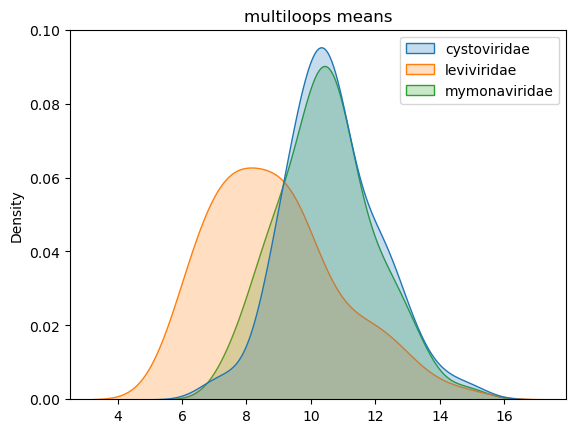

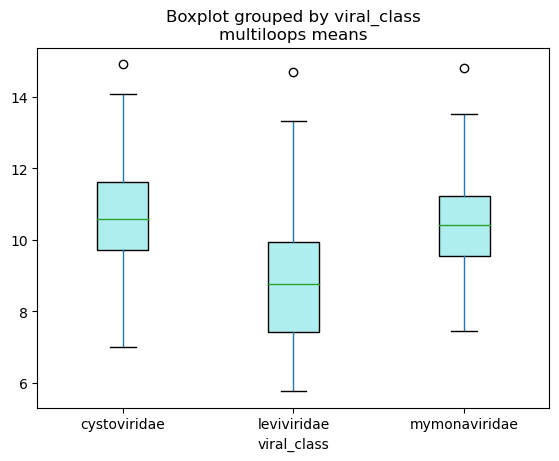


Variable =  hairpins means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  12.42610669514176 p_val= 0.0020031119202060612
P_val is less than alpha=0.05, H0 is rejected

Welch’s ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  100.82003596226188 p_val= 6.491758863224944e-28
P_val is less than alpha=0.05, H0 is rejected


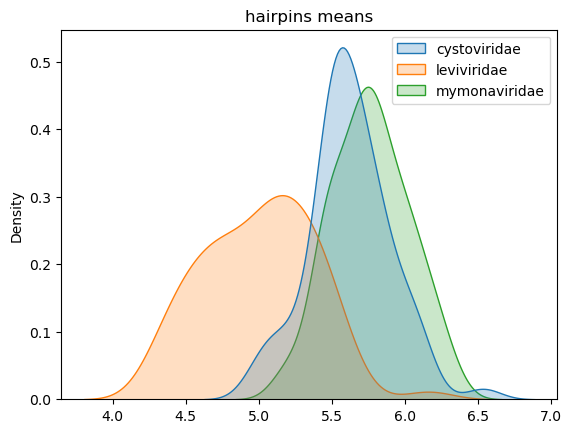

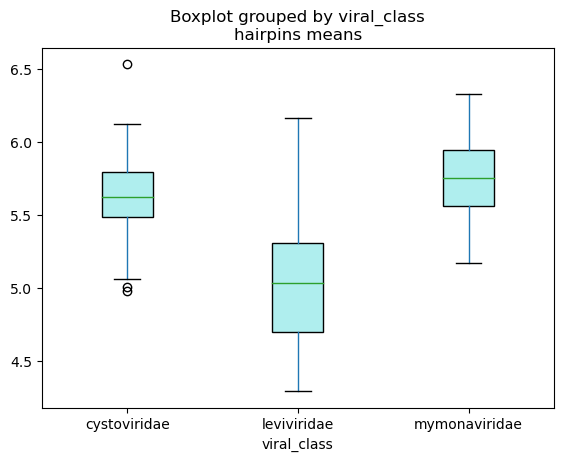


Variable =  interior loops means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  2.2608525315568615 p_val= 0.32289558774355287
P_val is greater than alpha=0.05, failed to reject H0 

One way ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  44.94474501373908 p_val= 4.786666136911796e-17
P_val is less than alpha=0.05, H0 is rejected


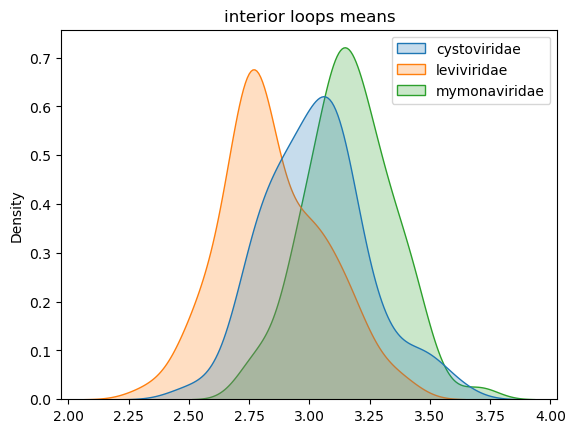

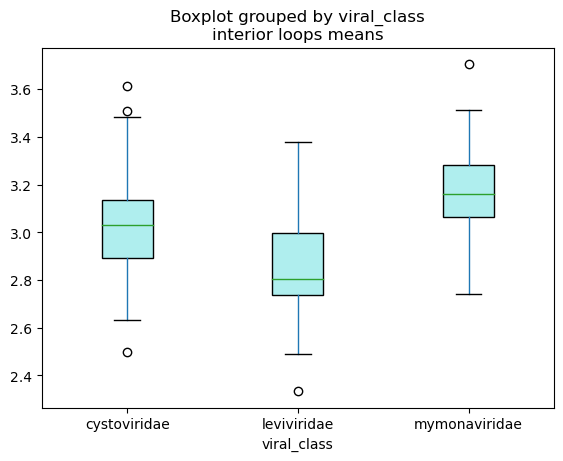


Variable =  stems means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  20.182332423835142 p_val= 4.144405087905614e-05
P_val is less than alpha=0.05, H0 is rejected

Welch’s ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  61.95600495116448 p_val= 5.562517520696643e-20
P_val is less than alpha=0.05, H0 is rejected


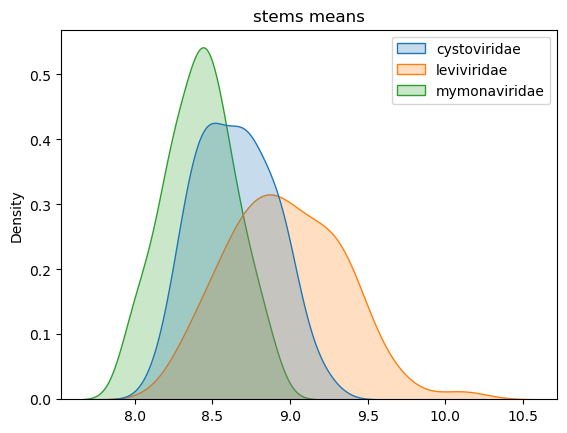

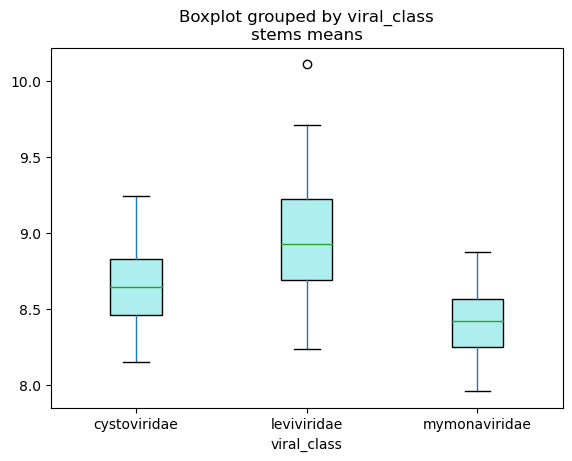

In [9]:
main(mymona_path,cysto_path,levi_path, sample_size=73)

structure counts are normalized by length, and expressed as a ratio per 1000 bases.


,viral_class,name,length,stems means,multiloops means,hairpins means,interior loops means
0,mymonaviridae,ND_096661,8721,8.029770,7.434211,5.171779,2.742000
1,mymonaviridae,ND_322189,9469,8.720000,11.025974,5.697917,3.280742
2,mymonaviridae,ND_098502,8100,8.083086,8.409091,5.412903,2.777042
3,mymonaviridae,ND_134714,9812,8.697548,10.971831,5.767956,3.313278
4,mymonaviridae,ND_127198,9857,8.348052,9.043478,5.707692,3.072464
...,...,...,...,...,...,...,...
68,cystoviridae,ND_250651,10484,8.763454,10.578947,5.506849,2.912698
69,cystoviridae,ND_046267,8029,8.880131,8.898551,5.494048,2.913978
70,cystoviridae,ND_301346,7212,9.000000,9.384615,5.827815,3.278287
71,cystoviridae,ND_370574,7099,8.319716,9.074074,5.748299,2.983425



Variable =  multiloops means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  0.030949934213667176 p_val= 0.8603521308041354
P_val is greater than alpha=0.05, failed to reject H0 

One way ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  0.4962862908283447 p_val= 0.48227422454196356
P_val is greater than alpha=0.05, failed to reject H0 


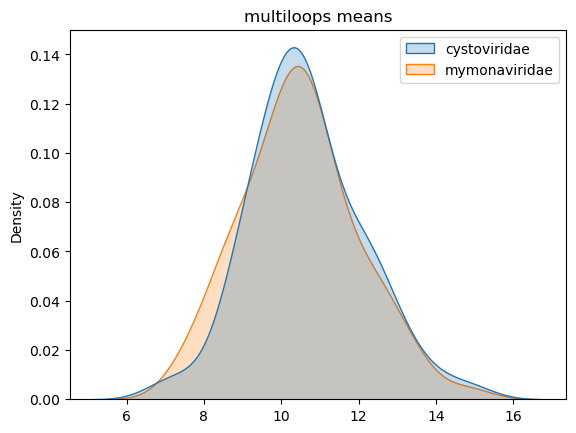

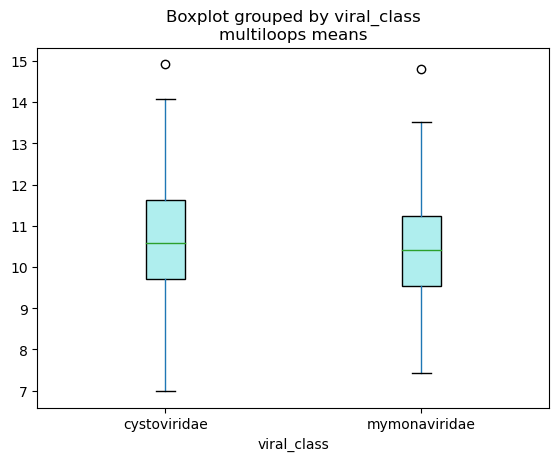


Variable =  hairpins means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  0.27939623071231773 p_val= 0.5970972217719739
P_val is greater than alpha=0.05, failed to reject H0 

One way ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  9.742777165130947 p_val= 0.0021759696343933896
P_val is less than alpha=0.05, H0 is rejected


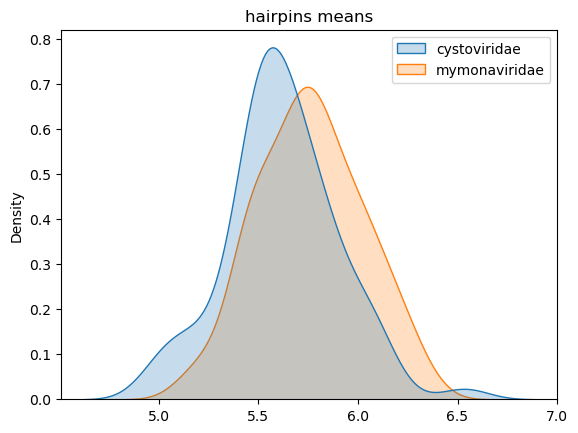

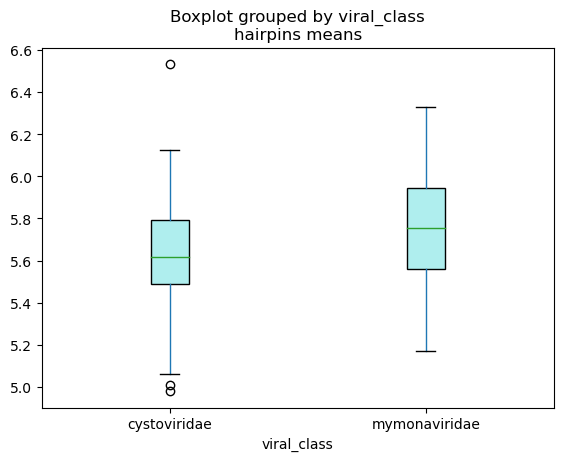


Variable =  interior loops means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  1.7797553935870822 p_val= 0.18217936556367906
P_val is greater than alpha=0.05, failed to reject H0 

One way ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  17.857675841465273 p_val= 4.205284542974485e-05
P_val is less than alpha=0.05, H0 is rejected


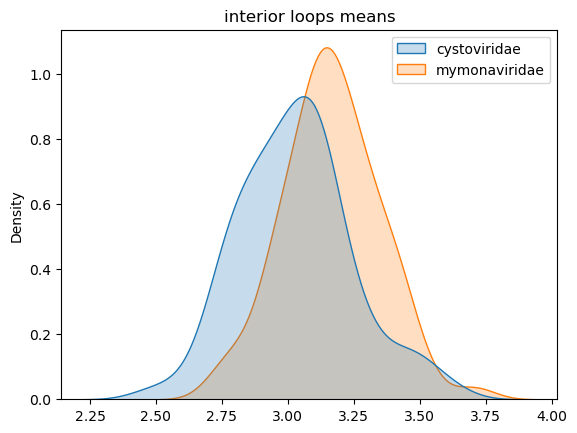

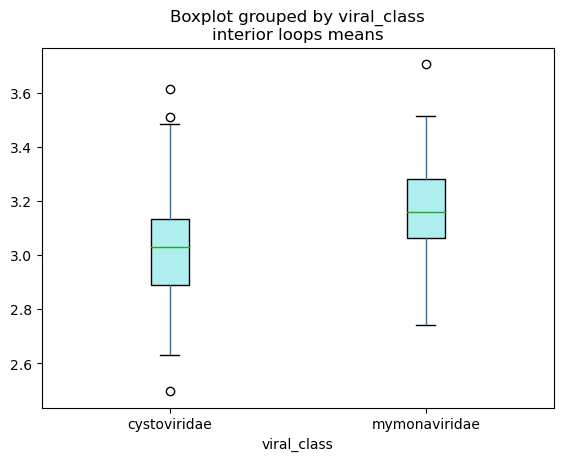


Variable =  stems means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  0.8042204344536004 p_val= 0.36983451704795856
P_val is greater than alpha=0.05, failed to reject H0 

One way ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  33.9668342130703 p_val= 3.5279108707578133e-08
P_val is less than alpha=0.05, H0 is rejected


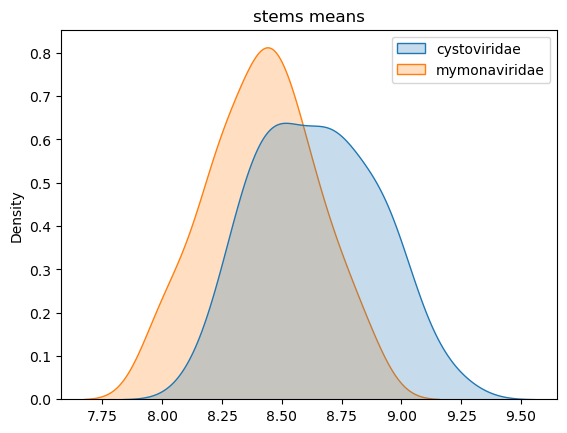

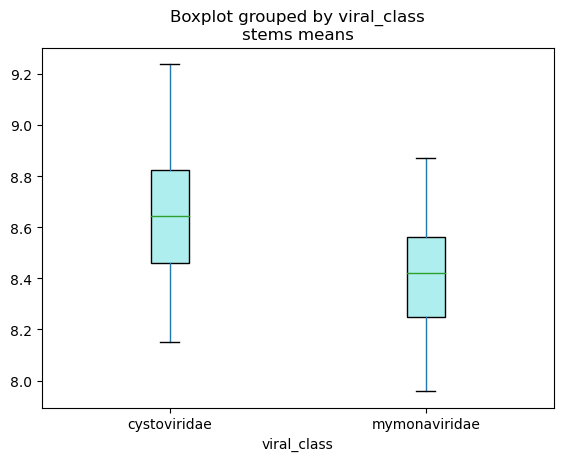

In [10]:
main(mymona_path,cysto_path, sample_size=73)

structure counts are normalized by length, and expressed as a ratio per 1000 bases.


,viral_class,name,length,stems means,multiloops means,hairpins means,interior loops means
0,cystoviridae,ND_192340,9063,8.492132,11.723077,5.675393,2.891648
1,cystoviridae,ND_301703,7116,8.430427,12.283019,5.791367,3.216138
2,cystoviridae,ND_301536,7108,8.190141,10.076923,5.669231,3.095855
3,cystoviridae,ND_015771,7051,8.803670,9.340000,5.006579,2.932945
4,cystoviridae,ND_301508,7094,8.283154,10.961538,5.780142,2.978082
...,...,...,...,...,...,...,...
68,leviviridae,ND_003428,3790,9.058419,7.451613,5.189873,2.834254
69,leviviridae,ND_003884,4761,8.385604,7.085714,5.315217,2.828244
70,leviviridae,ND_003080,3906,8.551020,12.437500,5.525773,2.775758
71,leviviridae,ND_000605,4011,9.215190,8.142857,4.319444,2.592593



Variable =  multiloops means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  6.65850598378311 p_val= 0.009868361712865134
P_val is less than alpha=0.05, H0 is rejected

Welch’s ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  38.07375023333407 p_val= 7.75214162666908e-09
P_val is less than alpha=0.05, H0 is rejected


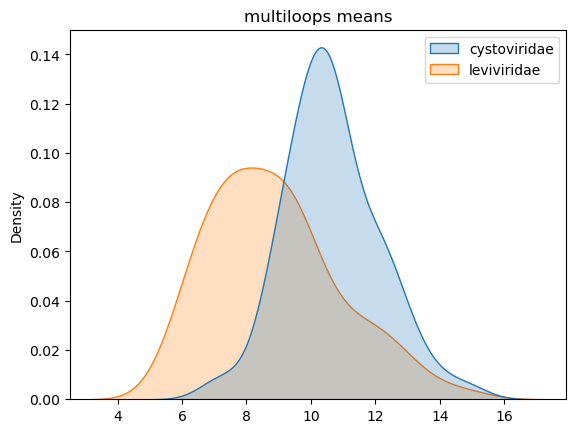

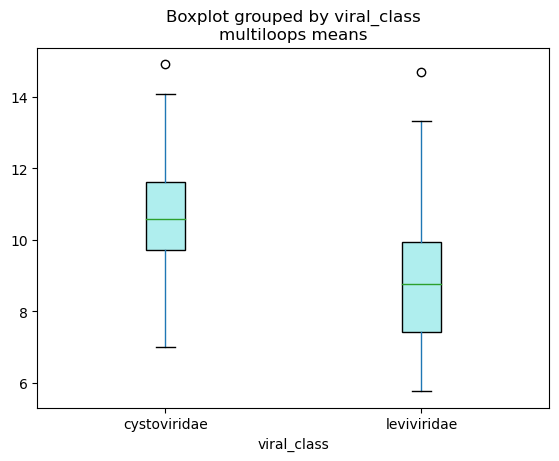


Variable =  hairpins means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  7.029938576150562 p_val= 0.008015810233653593
P_val is less than alpha=0.05, H0 is rejected

Welch’s ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  125.48191891451529 p_val= 7.167635166984011e-21
P_val is less than alpha=0.05, H0 is rejected


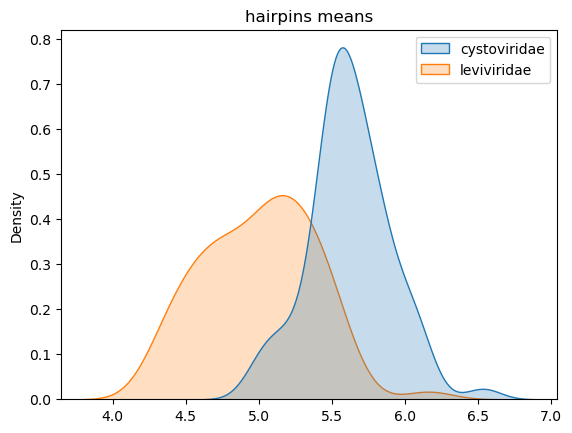

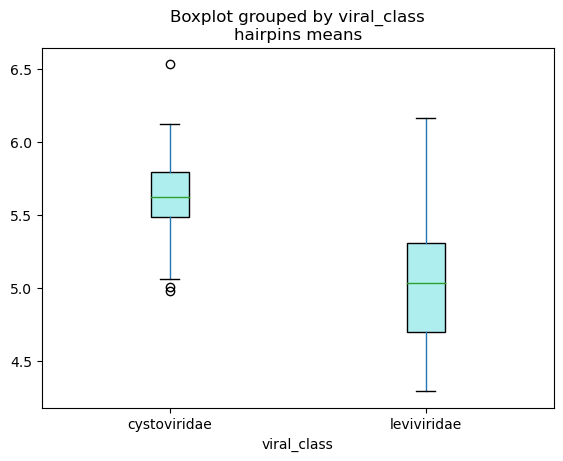


Variable =  interior loops means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  0.00042710763201943465 p_val= 0.9835116266294478
P_val is greater than alpha=0.05, failed to reject H0 

One way ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  25.878609669762284 p_val= 1.1155508028273083e-06
P_val is less than alpha=0.05, H0 is rejected


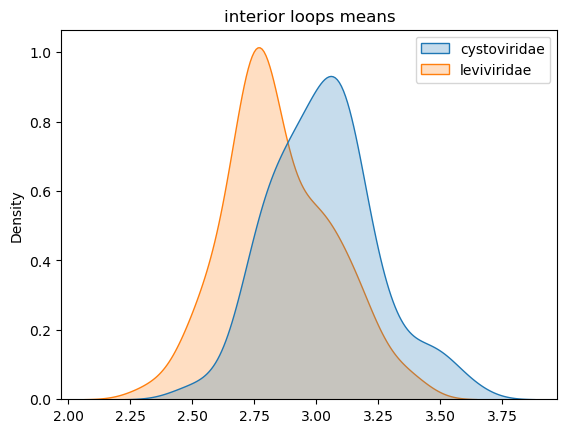

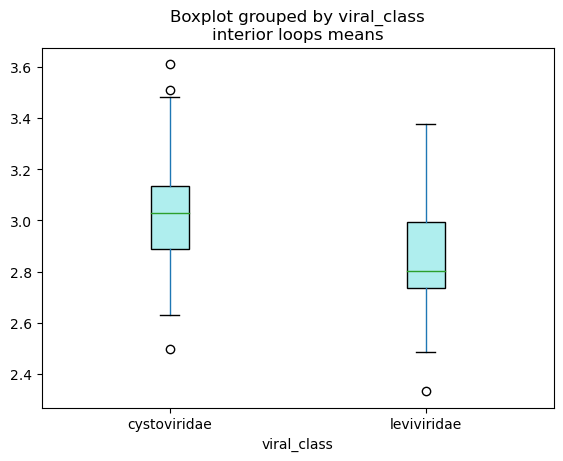


Variable =  stems means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  10.364076562734772 p_val= 0.0012849115501085866
P_val is less than alpha=0.05, H0 is rejected

Welch’s ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  38.511224607862815 p_val= 7.115472617998144e-09
P_val is less than alpha=0.05, H0 is rejected


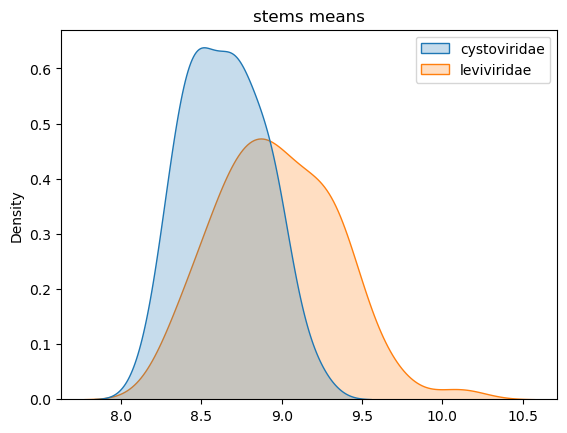

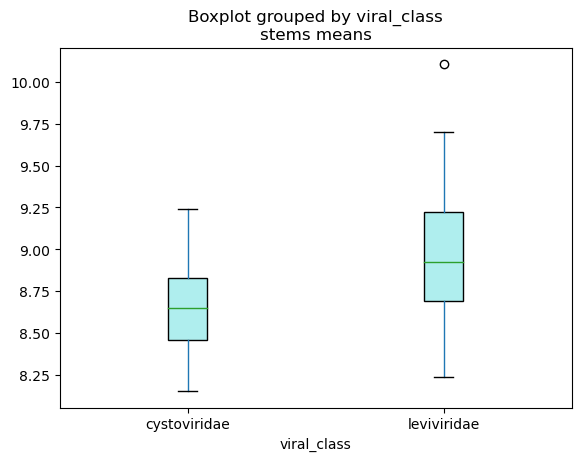

In [11]:
main(cysto_path,levi_path, sample_size=73)

structure counts are normalized by length, and expressed as a ratio per 1000 bases.


,viral_class,name,length,stems means,multiloops means,hairpins means,interior loops means
0,mymonaviridae,ND_096661,8721,8.029770,7.434211,5.171779,2.742000
1,mymonaviridae,ND_322189,9469,8.720000,11.025974,5.697917,3.280742
2,mymonaviridae,ND_098502,8100,8.083086,8.409091,5.412903,2.777042
3,mymonaviridae,ND_134714,9812,8.697548,10.971831,5.767956,3.313278
4,mymonaviridae,ND_127198,9857,8.348052,9.043478,5.707692,3.072464
...,...,...,...,...,...,...,...
68,leviviridae,ND_003428,3790,9.058419,7.451613,5.189873,2.834254
69,leviviridae,ND_003884,4761,8.385604,7.085714,5.315217,2.828244
70,leviviridae,ND_003080,3906,8.551020,12.437500,5.525773,2.775758
71,leviviridae,ND_000605,4011,9.215190,8.142857,4.319444,2.592593



Variable =  multiloops means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  5.799600039533286 p_val= 0.01602982049246881
P_val is less than alpha=0.05, H0 is rejected

Welch’s ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  30.612919612971783 p_val= 1.6019938483240845e-07
P_val is less than alpha=0.05, H0 is rejected


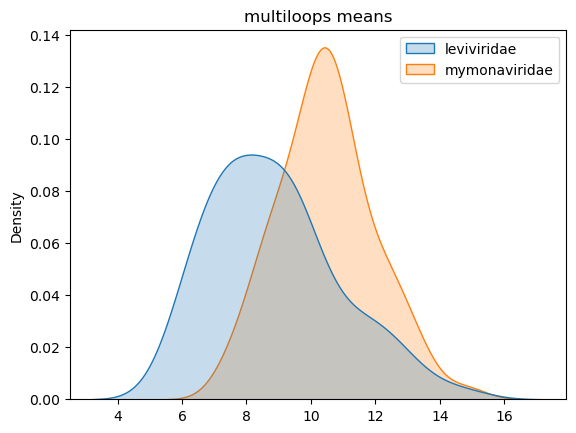

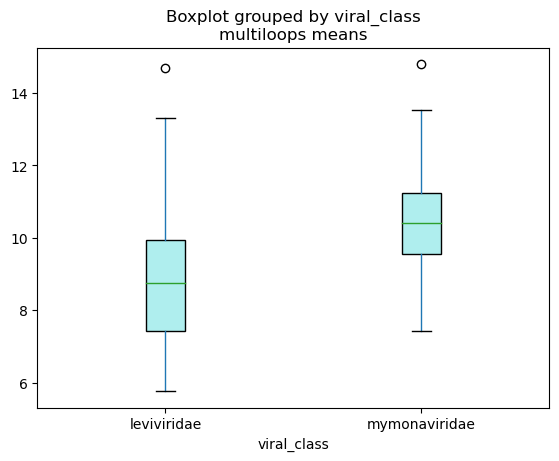


Variable =  hairpins means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  10.01633287675787 p_val= 0.00155158088313123
P_val is less than alpha=0.05, H0 is rejected

Welch’s ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  196.3744308001247 p_val= 1.4293239215858727e-27
P_val is less than alpha=0.05, H0 is rejected


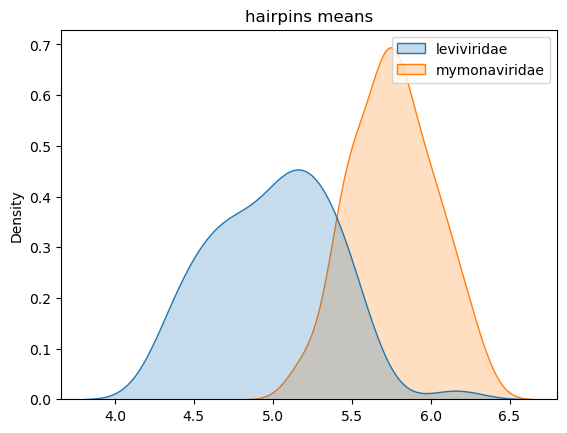

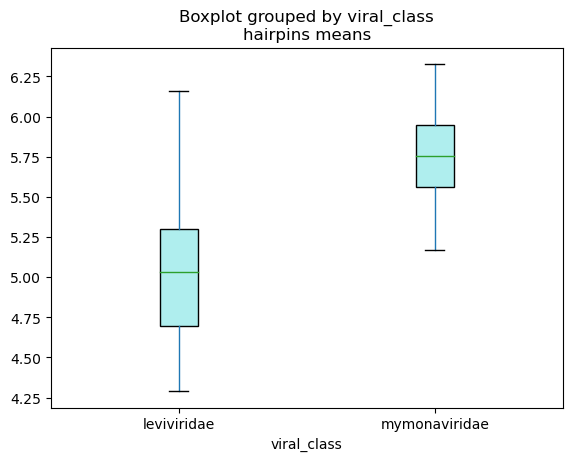


Variable =  interior loops means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  1.7253719018315992 p_val= 0.18900302923281556
P_val is greater than alpha=0.05, failed to reject H0 

One way ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  94.1724042403717 p_val= 1.9273810494496427e-17
P_val is less than alpha=0.05, H0 is rejected


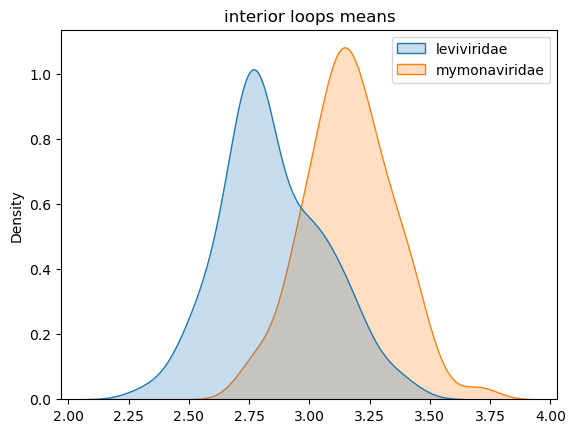

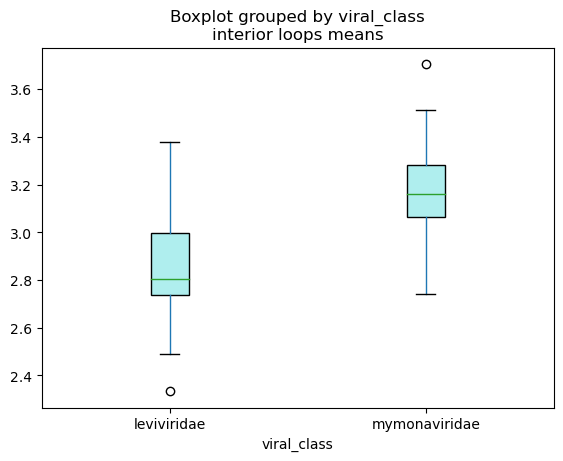


Variable =  stems means

Bartlett's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  16.618511227073835 p_val= 4.5702773862802626e-05
P_val is less than alpha=0.05, H0 is rejected

Welch’s ANOVA test: testing if samples have the same means
H0: means are equal
H1: means aren't equal
statistic =  119.91743795028239 p_val= 9.710476687961728e-20
P_val is less than alpha=0.05, H0 is rejected


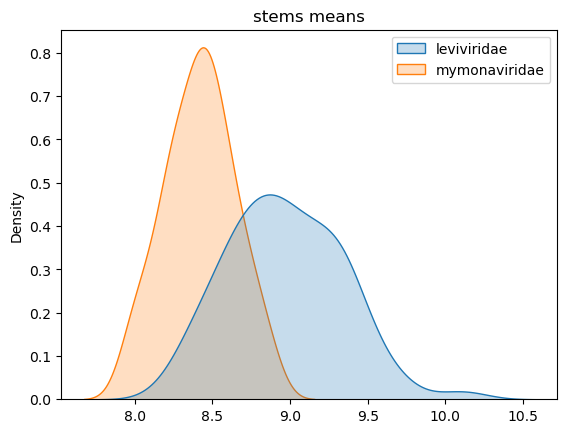

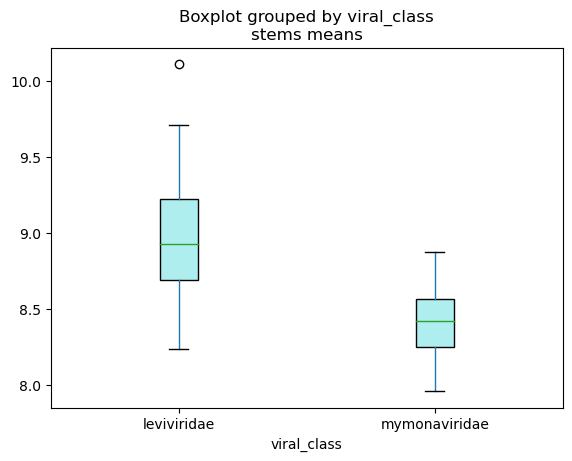

In [12]:
main(mymona_path,levi_path, sample_size=73)